In [1]:
papeis = ['ITSA4','SAPR11', 'CAML3',  'EGIE3', 'CXSE3', 'BBSE3', 'FLRY3', 'TAEE11', 'TUPY3', 'ABCB4' , 'BBAS3' , 'PSSSA3' , 'AMBP3']
papeis.sort()

In [5]:
import pandas as pd
url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/statusinvest-busca-avancada.csv'
tabela = pd.read_csv(url,sep=';' , decimal=',' , thousands='.')
tabela.head(2)

,TICKER,PRECO,DY,P/L,P/VP,P/ATIVOS,MARGEM BRUTA,MARGEM EBIT,MARG. LIQUIDA,P/EBIT,...,PATRIMONIO / ATIVOS,PASSIVOS / ATIVOS,GIRO ATIVOS,CAGR RECEITAS 5 ANOS,CAGR LUCROS 5 ANOS,LIQUIDEZ MEDIA DIARIA,VPA,LPA,PEG Ratio,VALOR DE MERCADO
0,AALR3,8.35,NaN,-3.75,0.97,0.36,30.1,1.60,-22.81,53.39,...,0.37,0.62,0.42,0.13,NaN,1571319.03,8.58,-2.22,-0.04,9.877450e+08
1,ABCB4,23.11,6.82,5.65,0.96,0.10,25.5,17.06,15.50,5.13,...,0.10,0.91,0.11,18.70,17.8,14518858.27,24.15,4.09,-0.31,5.475593e+09


In [6]:
## usar uma porcentagem do cagr 5y dos lucros como proxy de retorno futur0
projetado = tabela.loc[tabela['TICKER'].isin(papeis)][['TICKER' , 'CAGR LUCROS 5 ANOS']].set_index('TICKER').fillna(0)/111
projetado.rename(columns={'CAGR LUCROS 5 ANOS' : 'ret_projetado'},inplace=True)
projetado.head(2)

,ret_projetado
TICKER,
ABCB4,0.16036
AMBP3,0.00000


In [7]:
periodo = '5y'
intervalo = '1d'
ponto = 'Close'

#@ markdown Marque  a caixa se deseja usar retorno histórico,
#@ markdown caso contrário, usará o projetado
# Retorno_historico = False #@param ￼{type:"boolean"}

# parametros  para anualização
n_dias = 252

import numpy as np
import yfinance as yf
ativos = projetado.index.to_list()
n_ativos = len(ativos)

retorno_anual = projetado.copy()

In [8]:
# Download preços do yahoo finance
dados = yf.download( [tck+'.SA' for tck in ativos],
                    interval=intervalo,
                    auto_adjust=True,
                    progress=False )[ponto]

dados.columns = dados.columns.str.rstrip('.SA')
dados.index = dados.index.date
dados#.dropna(inplace=True)

,ABCB4,AMBP3,BBAS3,BBSE3,CAML3,CXSE3,EGIE3,FLRY3,ITSA4,SAPR11,TAEE11,TUPY3
2000-01-03,NaN,NaN,1.074564,NaN,NaN,NaN,NaN,NaN,0.407022,NaN,NaN,NaN
2000-01-04,NaN,NaN,1.023457,NaN,NaN,NaN,NaN,NaN,0.368161,NaN,NaN,NaN
2000-01-05,NaN,NaN,1.033940,NaN,NaN,NaN,NaN,NaN,0.398841,NaN,NaN,NaN
2000-01-06,NaN,NaN,1.048354,NaN,NaN,NaN,NaN,NaN,0.404977,NaN,NaN,NaN
2000-01-07,NaN,NaN,1.024767,NaN,NaN,NaN,NaN,NaN,0.402932,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,23.420000,14.14,55.990002,33.910000,8.53,13.57,41.880001,16.850000,10.080000,29.120001,37.630001,26.200920
2024-01-18,23.570000,14.08,55.340000,34.380001,8.44,13.67,41.099998,16.459999,9.990000,28.299999,37.220001,25.943468
2024-01-19,23.639999,14.34,55.919998,34.549999,8.57,13.78,40.810001,16.320000,10.040000,28.379999,37.349998,26.052389
2024-01-22,23.059999,14.36,55.549999,34.630001,8.49,13.93,40.490002,16.290001,9.910000,28.230000,36.919998,25.804838


In [9]:
# retorno histórico, tb usado coo proxy de retorno futuro
retornos = (dados.pct_change()).dropna()
retorno_anual['ret_historico']= retornos.mean()*n_dias

In [10]:
retorno_anual

,ret_projetado,ret_historico
TICKER,,
ABCB4,0.160360,0.289106
AMBP3,0.000000,-0.094788
BBAS3,0.231081,0.354949
BBSE3,0.122432,0.262109
CAML3,0.127027,0.075481
CXSE3,0.199279,0.256669
EGIE3,0.098829,0.090151
FLRY3,0.027928,-0.045417
ITSA4,0.100270,0.161060


In [11]:
#Volatilidade = dp retorno diário
riscos = retornos.std().dropna()
# volatilidade anualizada
vol_ano = riscos*np.sqrt(n_dias)
#covariancia anualizada
matriz_covarianca_ano = retornos.cov()*n_dias

In [12]:
matriz_covarianca_ano

,ABCB4,AMBP3,BBAS3,BBSE3,CAML3,CXSE3,EGIE3,FLRY3,ITSA4,SAPR11,TAEE11,TUPY3
ABCB4,0.098739,0.044088,0.043496,0.016643,0.037722,0.032520,0.017676,0.029042,0.038190,0.020319,0.015338,0.036668
AMBP3,0.044088,0.284835,0.034857,0.018571,0.043799,0.045798,0.020404,0.065437,0.036676,0.038473,0.022977,0.051772
BBAS3,0.043496,0.034857,0.081517,0.023509,0.027560,0.030028,0.017458,0.030442,0.043294,0.024416,0.016943,0.028849
BBSE3,0.016643,0.018571,0.023509,0.052783,0.017223,0.028876,0.014904,0.023531,0.018960,0.011881,0.013973,0.020415
CAML3,0.037722,0.043799,0.027560,0.017223,0.167708,0.021849,0.019885,0.031991,0.025254,0.026306,0.016532,0.032002
CXSE3,0.032520,0.045798,0.030028,0.028876,0.021849,0.093600,0.015183,0.028461,0.025266,0.019614,0.012964,0.031000
EGIE3,0.017676,0.020404,0.017458,0.014904,0.019885,0.015183,0.032506,0.019792,0.018177,0.019711,0.018242,0.014736
FLRY3,0.029042,0.065437,0.030442,0.023531,0.031991,0.028461,0.019792,0.110879,0.028944,0.026961,0.018109,0.031667
ITSA4,0.038190,0.036676,0.043294,0.018960,0.025254,0.025266,0.018177,0.028944,0.053134,0.019533,0.015139,0.026089
SAPR11,0.020319,0.038473,0.024416,0.011881,0.026306,0.019614,0.019711,0.026961,0.019533,0.068270,0.017766,0.018015


### ***otimização***

In [13]:
# caclula a volatilidade (aa) da carteira dada pelos pesos p
def volatilidade( p ):
  '''
  volatilidade da carteira definida por pesos p
  '''
  return  np.sqrt(np.dot(p.T,np.dot(matriz_covarianca_ano,p)))

# calcula a retorno esperado da carteira dada pelos pesos p
def retorno_esperado( p , tipo='p'):
  '''
  retorno da carteira definida por pesos p
  '''
  if tipo == 'p' : retornos = retorno_anual['ret_projetado']
  else : retornos = retorno_anual['ret_historico']

  return np.dot(retornos , p )

# a biblioteca de otimização tem um metodo de *minimização*
# para maximizar a função f calculamos o minimo de -f
def neg_ratio ( p , tipo='p') :
  sharpe = retorno_esperado(p,tipo) / volatilidade(p)
  return -sharpe


#### **carteira com a melhor razão retorno/risco**
**considerando que $0.05 \leq \text{peso} \leq 0.2$ e que as açoes de crescimento formam 30% da carteira**


In [14]:
limites   = tuple((0.05,.2) for x in range(n_ativos))     ## 0.05 ≤ peso ≤ 0.2

restricao = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},                ## a soma dos pesos é 1, i.e., np.sum(x) - 1 = 0
    {'type': 'ineq', 'fun' : lambda x: 0.3 -  x[2] - x[5] - x[7] - x[8]  } ## caml+flry+ofsa + mypk <= 30% , i.e., 0.3 -  x[2] - x[5] - x[7] - x[8] >= 0
    )                                                              ## x[2]=caml x[5]=flry ...

In [15]:
import scipy.optimize as scpopt

max_ratio = scpopt.minimize(neg_ratio,        # para max do ratio, calculamos min do -ratio = neg_ratio
                            x0 =  n_ativos * [1. / n_ativos] ,
                            args = 'p' ,
                            method='SLSQP',
                            bounds =  limites,
                            constraints =restricao
                            )

max_ratio_pesos_p = max_ratio['x']
print(max_ratio['message'])

Optimization terminated successfully


In [16]:
import scipy.optimize as scpopt

max_ratio = scpopt.minimize(neg_ratio,        # para max do ratio, calculamos min do -ratio = neg_ratio
                            x0 =  n_ativos * [1. / n_ativos] ,
                            args = 'h' ,
                            method='SLSQP',
                            bounds =  limites,
                            constraints =restricao
                            )

max_ratio_pesos_h = max_ratio['x']
print(max_ratio['message'])

Optimization terminated successfully


projetado

In [17]:
max_ratio_r = np.round( retorno_esperado(max_ratio_pesos_p,'p') ,4)
max_ratio_v = np.round( volatilidade(max_ratio_pesos_p),4)
max_ratio_s = np.round( -max_ratio['fun'],4)

# resultado
for x, y in zip(ativos, max_ratio_pesos_p):
  print(f'{x}: {100*y:.2f}%')
print('')
print('Retorno esperado %.2f' %(max_ratio_r*100)+'%')
print('Volatilidade %.2f' %(max_ratio_v*100)+'%')

ABCB4: 5.00%
AMBP3: 5.00%
BBAS3: 15.00%
BBSE3: 9.08%
CAML3: 5.00%
CXSE3: 5.00%
EGIE3: 5.00%
FLRY3: 5.00%
ITSA4: 5.00%
SAPR11: 13.67%
TAEE11: 13.61%
TUPY3: 13.64%

Retorno esperado 14.34%
Volatilidade 17.23%


historico

In [18]:
max_ratio_r = np.round( retorno_esperado(max_ratio_pesos_h,'h') ,4)
max_ratio_v = np.round( volatilidade(max_ratio_pesos_h),4)
max_ratio_s = np.round( -max_ratio['fun'],4)

# resultado
for x, y in zip(ativos, max_ratio_pesos_h):
  print(f'{x}: {100*y:.2f}%')
print('')
print('Retorno esperado %.2f' %(max_ratio_r*100)+'%')
print('Volatilidade %.2f' %(max_ratio_v*100)+'%')

ABCB4: 12.28%
AMBP3: 5.00%
BBAS3: 15.00%
BBSE3: 20.00%
CAML3: 5.00%
CXSE3: 5.00%
EGIE3: 5.00%
FLRY3: 5.00%
ITSA4: 5.00%
SAPR11: 12.72%
TAEE11: 5.00%
TUPY3: 5.00%

Retorno esperado 20.15%
Volatilidade 17.47%


**com qualquer proporção de ativos**

In [19]:
max = scpopt.minimize(neg_ratio, x0 =  n_ativos * [1. / n_ativos] ,args='p',  method='SLSQP',
                            bounds =  tuple((0,1) for asset in range(n_ativos)),
                            constraints =( {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})    )
max_pesos_p = max['x']

max_r = round( retorno_esperado(max_pesos_p, 'p'),4)
max_v = round( volatilidade(max_pesos_p),4)
max_s = round( -max['fun'],4)

# resultado
for x, y in zip(ativos, max_pesos_p):
  print(f'{x}: {100*y:.2f}%')
print(' ')
print('Retorno esperado %.2f' %(max_r*100)+'%')
print('Volatilidade %.2f' %(max_v*100)+'%')

ABCB4: 0.00%
AMBP3: 0.00%
BBAS3: 29.20%
BBSE3: 4.80%
CAML3: 0.00%
CXSE3: 16.36%
EGIE3: 2.62%
FLRY3: 0.00%
ITSA4: 0.00%
SAPR11: 13.64%
TAEE11: 20.30%
TUPY3: 13.07%
 
Retorno esperado 17.66%
Volatilidade 17.67%


In [20]:
max = scpopt.minimize(neg_ratio, x0 =  n_ativos * [1. / n_ativos] ,args='h',  method='SLSQP',
                            bounds =  tuple((0,1) for asset in range(n_ativos)),
                            constraints =( {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})    )
max_pesos_h = max['x']

max_r = round( retorno_esperado(max_pesos_h,'h'),4)
max_v = round( volatilidade(max_pesos_h),4)
max_s = round( -max['fun'],4)

# resultado
for x, y in zip(ativos, max_pesos_h):
  print(f'{x}: {100*y:.2f}%')
print(' ')
print('Retorno esperado %.2f' %(max_r*100)+'%')
print('Volatilidade %.2f' %(max_v*100)+'%')

ABCB4: 11.25%
AMBP3: 0.00%
BBAS3: 29.19%
BBSE3: 37.24%
CAML3: 0.00%
CXSE3: 4.93%
EGIE3: 0.00%
FLRY3: 0.00%
ITSA4: 0.00%
SAPR11: 17.39%
TAEE11: 0.00%
TUPY3: 0.00%
 
Retorno esperado 28.45%
Volatilidade 18.60%


#### **Carteira de menor volatilidade**


**considerando que $0.05 \leq \text{peso} \leq 0.2$ e que as açoes de crescimento formam 30% da carteira**

In [21]:
min_vol_P = scpopt.minimize(volatilidade,
                          x0 =  n_ativos * [1. / n_ativos] ,
                          method='SLSQP',
                          bounds = limites ,
                          constraints = restricao)

min_vol_pesos_P = min_vol_P['x']

min_volP_r = round( retorno_esperado(min_vol_pesos_P,'p'),4)
min_volP_v = round( min_vol_P['fun'],4)
min_volP_s = round( -neg_ratio(min_vol_pesos_P),4)

for x, y in zip(ativos, min_vol_pesos_P):
  print(f'{x}: {100*y:.2f}% ')
print(' ')
print('Retorno esperado %.2f' %(100*min_volP_r)+'%')
print('Volatilidade %.2f' %(100*min_volP_v)+'%')

ABCB4: 5.00% 
AMBP3: 5.00% 
BBAS3: 5.00% 
BBSE3: 14.69% 
CAML3: 5.00% 
CXSE3: 5.00% 
EGIE3: 20.00% 
FLRY3: 5.00% 
ITSA4: 5.00% 
SAPR11: 5.31% 
TAEE11: 20.00% 
TUPY3: 5.00% 
 
Retorno esperado 11.95%
Volatilidade 15.65%


In [22]:
min_vol_P = scpopt.minimize(volatilidade,
                          x0 =  n_ativos * [1. / n_ativos] ,
                          method='SLSQP',
                          bounds = limites ,
                          constraints = restricao)

min_vol_pesos_P = min_vol_P['x']

min_volP_r = round( retorno_esperado(min_vol_pesos_P,'h'),4)
min_volP_v = round( min_vol_P['fun'],4)
min_volP_s = round( -neg_ratio(min_vol_pesos_P),4)

for x, y in zip(ativos, min_vol_pesos_P):
  print(f'{x}: {100*y:.2f}% ')
print(' ')
print('Retorno esperado %.2f' %(100*min_volP_r)+'%')
print('Volatilidade %.2f' %(100*min_volP_v)+'%')

ABCB4: 5.00% 
AMBP3: 5.00% 
BBAS3: 5.00% 
BBSE3: 14.69% 
CAML3: 5.00% 
CXSE3: 5.00% 
EGIE3: 20.00% 
FLRY3: 5.00% 
ITSA4: 5.00% 
SAPR11: 5.31% 
TAEE11: 20.00% 
TUPY3: 5.00% 
 
Retorno esperado 14.05%
Volatilidade 15.65%


**considerando qualquer proporção de ativos**


In [23]:
min_vol = scpopt.minimize(volatilidade,
                          x0 =  n_ativos * [1. / n_ativos] ,
                          method='SLSQP',
                          bounds = tuple((0,1) for asset in range(n_ativos)),
                          constraints = ( {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})    )

min_vol_pesos = min_vol['x']

min_vol_r = round( retorno_esperado(min_vol_pesos,'p'),4)
min_vol_v = round( min_vol['fun'],4)
min_vol_s = round( -neg_ratio(min_vol_pesos,'p'),4)

for x, y in zip(ativos, min_vol_pesos):
  print(f'{x}: {100*y:.2f}% ')
print(' ')
print('Retorno esperado %.2f' %(min_vol_r*100)+'%')
print('Volatilidade %.2f' %(min_vol_v*100)+'%')

ABCB4: 1.56% 
AMBP3: 0.00% 
BBAS3: 0.00% 
BBSE3: 15.62% 
CAML3: 0.87% 
CXSE3: 3.46% 
EGIE3: 26.90% 
FLRY3: 0.00% 
ITSA4: 8.72% 
SAPR11: 7.28% 
TAEE11: 32.01% 
TUPY3: 3.59% 
 
Retorno esperado 11.76%
Volatilidade 14.62%


In [24]:
min_vol = scpopt.minimize(volatilidade,
                          x0 =  n_ativos * [1. / n_ativos] ,
                          method='SLSQP',
                          bounds = tuple((0,1) for asset in range(n_ativos)),
                          constraints = ( {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})    )

min_vol_pesos = min_vol['x']

min_vol_r = round( retorno_esperado(min_vol_pesos,'h'),4)
min_vol_v = round( min_vol['fun'],4)
min_vol_s = round( -neg_ratio(min_vol_pesos,'h'),4)

for x, y in zip(ativos, min_vol_pesos):
  print(f'{x}: {100*y:.2f}% ')
print(' ')
print('Retorno esperado %.2f' %(min_vol_r*100)+'%')
print('Volatilidade %.2f' %(min_vol_v*100)+'%')

ABCB4: 1.56% 
AMBP3: 0.00% 
BBAS3: 0.00% 
BBSE3: 15.62% 
CAML3: 0.87% 
CXSE3: 3.46% 
EGIE3: 26.90% 
FLRY3: 0.00% 
ITSA4: 8.72% 
SAPR11: 7.28% 
TAEE11: 32.01% 
TUPY3: 3.59% 
 
Retorno esperado 13.96%
Volatilidade 14.62%


### gráfico com as carteiras sorteadas e a fronteira

In [25]:
# carteiras sorteadas
prets = []
pvols = []
for p in range (25000):
 weights = np.random.random(n_ativos)
 weights /= np.sum(weights)
 prets.append(np.sum(retorno_anual['ret_projetado'] * weights) )
 pvols.append(np.sqrt(np.dot(weights.T,np.dot(matriz_covarianca_ano, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

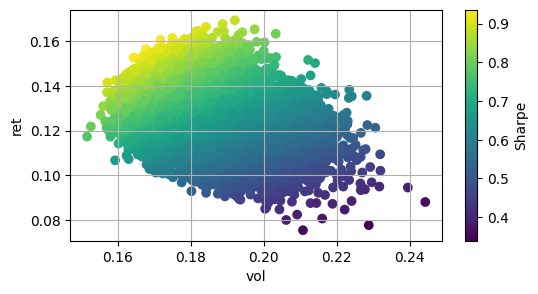

In [26]:
# grafico riscoXretorno das sorteadas
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 3))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('vol')
plt.ylabel('ret')
plt.colorbar(label='Sharpe')

In [27]:
def fronteira (rtns , cov , rtn_range):
  """
    Essa função determina os pontos (x,y) da fronteira dos ativos
    a parte superior da fronteira é a fronteira eficiente.
    <rtns> é o retorno anualizado dos ativos
    <cov> é a matriz das covs anualizadas
    <rtn_rng> é o intervalo dos retornos pros quais computamos a volatilidade minima
  """
  eficientes = []
  n =  len(rtns)
  x0 = n * [1./n]

  for y in rtn_range:                                   # para cada retorno no intervalo, determina
     pontos = scpopt.minimize(volatilidade,             #     minimiza a volatilidade
                             x0,
                             method='SLSQP',
                             bounds = tuple((0.0,1.0) for a in range(n)) ,
                             constraints =
                             ({'type' : 'eq', 'fun': lambda x: retorno_esperado(x)  - y},
                              {'type' : 'eq', 'fun': lambda x: np.sum(x)-1}               )
                             )
     eficientes.append(pontos)
  return eficientes


In [28]:
# fronteira
y_front_range = np.linspace(retorno_anual['ret_projetado'].min() ,retorno_anual['ret_projetado'].max(),200)
front_ef = fronteira (retorno_anual['ret_projetado'] , matriz_covarianca_ano , y_front_range)
x_front_range = [x['fun'] for x in front_ef]

In [29]:
import plotly
import plotly.graph_objects as go
plotly.io.renderers.default = 'colab'

In [30]:
# # !pip install gitly -q
# from gitly.colab.plot import GitlyPlotter
# gitly = GitlyPlotter('github')


In [31]:
# !pip install -U kaleido

In [32]:
fig = go.Figure()

# curva da fronteira
fig.add_trace(go.Scatter(x=x_front_range ,y = y_front_range, showlegend=False))

# carteiras sorteadas
fig.add_trace( go.Scatter(x=pvols, y=prets,
                           marker=dict(color=prets / pvols,
                           showscale=True,
                           size=7,
                           line=dict(width=1),
                           colorscale="RdYlGn",
                           colorbar=dict(title='"Sharpe" '))
                        )
)



# cada ativo
x1=[]
y1=[]
for index in range(n_ativos):
  x = [np.sqrt(matriz_covarianca_ano.iloc[index, index])]
  x1.append(x)
  y = [retorno_anual['ret_projetado'][index]]
  y1.append(y)
  fig.add_trace(go.Scatter(x=x, y=y,#
      mode='markers+text',
      text = ativos[index],
      textposition='middle right',
      showlegend=False,
      marker=dict(size=10, color='black', symbol = 'cross' )
      )
  )
# ponto de menor volatilidade --------------- -------------------
fig.add_trace(go.Scatter(x=[min_vol_v], y=[min_vol_r],
                         mode='markers+text',text = 'Min vol',
                         textposition='middle left',      showlegend=False,
                         marker=dict(size=10, color='blue', symbol = 'square' )))
# ponto de menor volatilidade com criterios plena  -------------------
fig.add_trace(go.Scatter(x=[min_volP_v], y=[min_volP_r],
                         mode='markers+text',text = 'Min vol Plena',
                         textposition='middle left',      name = 'min vol com criterios Regito',
                         marker=dict(size=10, color='blue', symbol = 'triangle-up' )))

# ponto de maior sharpe -----------------------------------
fig.add_trace(go.Scatter(x=[max_v], y=[max_r],
                         mode='markers+text',text = 'Max Sharpe',
                         textposition='middle left',      showlegend=False,
                         marker=dict(size=10, color='red', symbol = 'square' )))
# ponto de maior sharpe com criterios plena -----------------
fig.add_trace(go.Scatter(x=[max_ratio_v], y=[max_ratio_r],
                         mode='markers+text',text = 'Max Sharpe Plena',
                         textposition='top center',      name = 'max "Sharpe" com criterios Regito',
                         marker=dict(size=10, color='red', symbol = 'triangle-up' )))

# plena no grafico (bola azul) -----------------------------------
pesos =np.array([.05,.05,.15,.05,.1,.1,.1,.06,.05,0.19,0.05,0.05])
fig.add_trace(go.Scatter(x=np.array(volatilidade(pesos)), y=np.array(retorno_esperado( pesos ,'p' )),
                         mode='markers+text',text = 'pesos atuais da Plena',
                         textposition='middle right',      showlegend=False,
                         marker=dict(size=12, color='blue',  symbol = 'circle' )))

# parametros do grafico -----------------------------------
minX = np.array([min_vol_v,min_volP_v,max_v,volatilidade(pesos),np.array(x_front_range).min(),np.array(x1).min()]).min()
maxX = np.array([min_vol_v,min_volP_v,max_v,volatilidade(pesos),np.array(x_front_range).max(),np.array(x1).max()]).max()


fig.update_xaxes(range=[ minX - 0.035 , maxX + 0.025])
#fig.update_yaxes(range=[ retornos_medio_ano.min() -.025 , retornos_medio_ano.max() + .025 ])
#
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Volatilidade (anualizado)'),
                  yaxis=dict(title='Retorno (anualizado)'),
                  title='',
                  width=999,height=500)

fig.show()
# gitly.show( fig )